In [ ]:
# default_exp core

# ImStack core

> Defining the key ImStack class.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export

import torch
import torch.nn as nn 
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

class ImStack(nn.Module):
  """ This class represents an image as a series of stacked arrays, where each is 1/scale
  the resolution of the next. This is useful eg when trying to create an image to minimise
  some loss - parameters in the early (small) layers can have an effect on the overall 
  structure and shapes while those in later layers act as residuals and fill in fine detail.
  """

  def __init__(self, n_layers=4, base_size=32, scale=2,
               init_image=None, out_size=256, decay=0.7,
              device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')):
    """Constructs the Image Stack

    Args:
        n_layers: How many layers in the stack
        base_size: The size of the smallest layer
        scale: how much larger each subsequent layer is
        init_image: Pass in a PIL image if you don't want to start from noise
        out_size: The output size. Works best if output size ~= base_size * (scale ** (n_layers-1))
        decay: When initializing with noise, decay controls scaling of later layers (avoiding too miuch high-frequency noise)

    """
    super().__init__()
    self.n_layers = n_layers
    self.base_size = base_size
    self.sig = nn.Sigmoid()
    self.layers = []
    self.device=device

    for i in range(n_layers):
        side = base_size * (scale**i)
        tim = torch.randn((3, side, side)).to(device)*(decay**i)
        self.layers.append(tim)

    self.scalers = [nn.Upsample(scale_factor=out_size/(l.shape[1]), mode='bilinear', align_corners=False) for l in self.layers]
    
    self.preview_scalers = [nn.Upsample(scale_factor=224/(l.shape[1]), mode='bilinear', align_corners=False) for l in self.layers]
    
    if init_image != None: # Given a PIL image, decompose it into a stack
      if type(init_image) == str:
        try:
          init_image = Image.open(init_image)
        except:
          raise Exception(f"couldn't open {init_image}")
            
      init_image = init_image.convert('RGB')
      downscalers = [nn.Upsample(scale_factor=(l.shape[1]/out_size), mode='bilinear', align_corners=False) for l in self.layers]
      final_side = base_size * (scale ** n_layers)
      im = torch.tensor(np.array(init_image.resize((out_size, out_size)))/255).clip(1e-03, 1-1e-3) # Between 0 and 1 (non-inclusive)
      im = im.permute(2, 0, 1).unsqueeze(0).to(device) # torch.log(im/(1-im))
      for i in range(n_layers):self.layers[i] *= 0 # Sero out the layers
      for i in range(n_layers):
        side = base_size * (scale**i)
        out = self.forward()
        residual = (torch.logit(im) - torch.logit(out))
        Image.fromarray((torch.logit(residual).detach().cpu().squeeze().permute([1, 2, 0]) * 255).numpy().astype(np.uint8)).save(f'residual{i}.png')
        self.layers[i] = downscalers[i](residual).squeeze().float()
    
    for l in self.layers: l.requires_grad = True

  def forward(self):
    """Sums the stacked layers (upsampling them all to out_size) and then runs the result through a sigmoid funtion.
    Resulting image is a tensor, with values between 0 and 1."""
    im = self.scalers[0](self.layers[0].unsqueeze(0))
    for i in range(1, self.n_layers):
      im += self.scalers[i](self.layers[i].unsqueeze(0))
    return self.sig(im)

  def preview(self, n_preview=2):
    """Creates an image using only the first n_preview layers. Useful if you want to optimise the first few layers before starting to optimize the entire stack."""
    im = self.preview_scalers[0](self.layers[0].unsqueeze(0))
    for i in range(1, n_preview):
      im += self.preview_scalers[i](self.layers[i].unsqueeze(0))
    return self.sig(im)
  
  def to_pil(self):
    """Return the result as a PIL Image (useful for saving, transforming, viewing etc)"""
    return Image.fromarray((self.forward().detach().cpu().squeeze().permute([1, 2, 0]) * 255).numpy().astype(np.uint8))

  def preview_pil(self):
    return Image.fromarray((self.preview().detach().cpu().squeeze().permute([1, 2, 0]) * 255).numpy().astype(np.uint8))

  def save(self, fn):
    """Save the image to a given filename (fn)"""
    self.to_pil().save(fn)

  def plot_layers(self):
    """View the layers in the stack - nice to build intuition about what's happening."""
    fig, axs = plt.subplots(1, self.n_layers, figsize=(15, 5))
    for i in range(self.n_layers):
      im = (self.sig(self.layers[i].unsqueeze(0)).detach().cpu().squeeze().permute([1, 2, 0]) * 255).numpy().astype(np.uint8)
      axs[i].imshow(im)

In [ ]:
ims = ImStack()

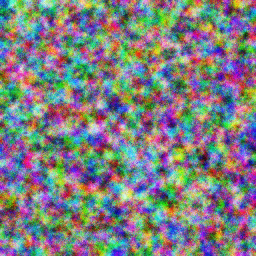

In [ ]:
ims.to_pil()

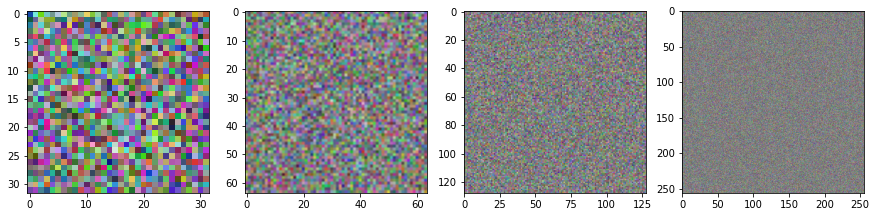

In [ ]:
ims.plot_layers()

### Included functions

In [ ]:
show_doc(ImStack().__init__)

<h4 id="ImStack.__init__" class="doc_header"><code>ImStack.__init__</code><a href="__main__.py#L16" class="source_link" style="float:right">[source]</a></h4>

> <code>ImStack.__init__</code>(**`n_layers`**=*`4`*, **`base_size`**=*`32`*, **`scale`**=*`2`*, **`init_image`**=*`None`*, **`out_size`**=*`256`*, **`decay`**=*`0.7`*, **`device`**=*`device(type='cpu')`*)

Constructs the Image Stack

Args:
    n_layers: How many layers in the stack
    base_size: The size of the smallest layer
    scale: how much larger each subsequent layer is
    init_image: Pass in a PIL image if you don't want to start from noise
    out_size: The output size. Works best if output size ~= base_size * (scale ** (n_layers-1))
    decay: When initializing with noise, decay controls scaling of later layers (avoiding too miuch high-frequency noise)

In [ ]:
show_doc(ImStack().forward)

<h4 id="ImStack.forward" class="doc_header"><code>ImStack.forward</code><a href="__main__.py#L68" class="source_link" style="float:right">[source]</a></h4>

> <code>ImStack.forward</code>()

Sums the stacked layers (upsampling them all to out_size) and then runs the result through a sigmoid funtion.
Resulting image is a tensor, with values between 0 and 1.

In [ ]:
show_doc(ImStack().preview)

<h4 id="ImStack.preview" class="doc_header"><code>ImStack.preview</code><a href="__main__.py#L76" class="source_link" style="float:right">[source]</a></h4>

> <code>ImStack.preview</code>(**`n_preview`**=*`2`*)

Creates an image using only the first n_preview layers. Useful if you want to optimise the first few layers before starting to optimize the entire stack.

In [ ]:
show_doc(ImStack().to_pil)

<h4 id="ImStack.to_pil" class="doc_header"><code>ImStack.to_pil</code><a href="__main__.py#L83" class="source_link" style="float:right">[source]</a></h4>

> <code>ImStack.to_pil</code>()

Return the result as a PIL Image (useful for saving, transforming, viewing etc)

In [ ]:
show_doc(ImStack().save)

<h4 id="ImStack.save" class="doc_header"><code>ImStack.save</code><a href="__main__.py#L90" class="source_link" style="float:right">[source]</a></h4>

> <code>ImStack.save</code>(**`fn`**)

Save the image to a given filename (fn)

In [ ]:
show_doc(ImStack().plot_layers)

<h4 id="ImStack.plot_layers" class="doc_header"><code>ImStack.plot_layers</code><a href="__main__.py#L94" class="source_link" style="float:right">[source]</a></h4>

> <code>ImStack.plot_layers</code>()

View the layers in the stack - nice to build intuition about what's happening.

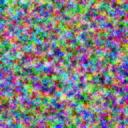

In [ ]:
#hide

#test converting to RGB, init image etc
ims2 = ImStack(init_image = ims.to_pil().convert('RGBA'), out_size=128)
ims2.to_pil()